In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

### This week, I worked on optimizing the patching code:
#### I made it significantly more consistent at choosing matching sections of the scan
#### I guaranteed that a section of the epithelium is selected using largest contour


### rotating tif masks

In [3]:
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(blurred, kernel, iterations=1)
    cleaned_edges = cv2.erode(dilated, kernel, iterations=1)
    return cleaned_edges

# Find the largest contour by area
def find_largest_contour(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

# Fill a contour to create a mask of the shape
def fill_contour(img_shape, contour):
    mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
    return mask

# Calculate the center of mass of a filled contour
def get_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = mask.shape[1] // 2, mask.shape[0] // 2  # Default to center if no mass
    return cX, cY

# Center the image based on center of mass
def center_image(mask):
    cX, cY = get_center_of_mass(mask)
    shiftX = mask.shape[1] // 2 - cX
    shiftY = mask.shape[0] // 2 - cY
    translation_matrix = np.float32([[1, 0, shiftX], [0, 1, shiftY]])
    centered_mask = cv2.warpAffine(mask, translation_matrix, (mask.shape[1], mask.shape[0]))
    return centered_mask

# Combines the above functions for the pipeline
def pipeline_helper(tif_path):
    image = cv2.imread(tif_path, 0)
    edges = cv2.Canny(image, 50, 100)
    cleaned_edges = clean_edges(edges)
    contours, _ = cv2.findContours(cleaned_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = find_largest_contour(contours)
    mask = fill_contour(cleaned_edges.shape, largest_contour)
    centered_mask = center_image(mask)
    return centered_mask

In [4]:
# Rotate the image around its center
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h))
    return rotated_image

# Pad an image symmetrically to match the target size
def pad_to_size(image, target_size):
    h, w = image.shape[:2]
    pad_top = (target_size[1] - h) // 2
    pad_bottom = target_size[1] - h - pad_top
    pad_left = (target_size[0] - w) // 2
    pad_right = target_size[0] - w - pad_left
    padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)
    return padded_image


In [5]:
# Mirror the image either horizontally or vertically
def mirror_image(image, direction='horizontal'):
    if direction == 'horizontal':
        mirrored_image = cv2.flip(image, 1)  # Horizontal flip
    elif direction == 'vertical':
        mirrored_image = cv2.flip(image, 0)  # Vertical flip
    else:
        raise ValueError("Direction should be either 'horizontal' or 'vertical'")
    return mirrored_image

# Function to find the optimal rotation and flip for alignment
def find_best_rotation_with_flip(mask1, mask2, angles=np.arange(-90, 91, 1)):
    best_overlap = 0
    best_angle = 0
    best_flip = None

    for flip in [None, 'horizontal', 'vertical']:
        flipped_mask2 = mirror_image(mask2, flip) if flip else mask2
        for angle in angles:
            rotated_mask2 = rotate_image(flipped_mask2, angle)
            intersection = cv2.bitwise_and(mask1, rotated_mask2)
            union = cv2.bitwise_or(mask1, rotated_mask2)
            similarity_score = np.sum(intersection) / np.sum(union)

            if similarity_score > best_overlap:
                best_overlap = similarity_score
                best_angle = angle
                best_flip = flip

    return best_overlap, best_angle, best_flip


In [6]:
# Main pipeline with optimal flip function
def pipeline_with_optimal_flip(path1, path2):
    mask1 = pipeline_helper(path1)
    mask2 = pipeline_helper(path2)

    # Step 1: Get maximum width and height to resize all three images
    max_width = max(mask1.shape[1], mask2.shape[1])
    max_height = max(mask1.shape[0], mask2.shape[0])

    # Step 2: Resize and pad all masks to the same size
    mask1 = pad_to_size(mask1, (max_width, max_height))
    mask2 = pad_to_size(mask2, (max_width, max_height))

    # Step 3: Find the best rotation and flip for mask2 that maximizes overlap with mask1
    best_overlap_2, angle2, flip2 = find_best_rotation_with_flip(mask1, mask2)
    mask2_flipped = mirror_image(mask2, flip2) if flip2 else mask2
    mask2_transformed = rotate_image(mask2_flipped, angle2)

    return mask1, mask2, mask2_transformed, angle2, flip2


In [7]:
paths = ['patient1/h1810898A mela_ROI_1.tif', 'patient1/h1810898A sox10_ROI_1.tif']

melana, sox, sox_rotated, angle2, flip2 = pipeline_with_optimal_flip(paths[0], paths[1])

In [8]:
# Create a 3x3 kernel for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

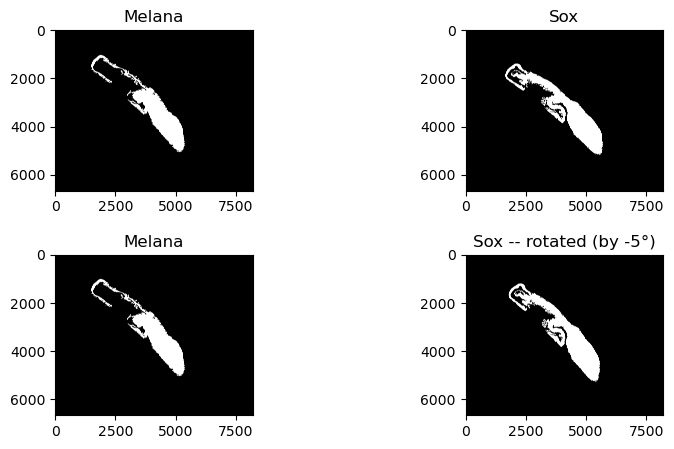

In [9]:
plt.figure(figsize=(15, 5))

# Original images
plt.subplot(2, 3, 2)
plt.title('Melana')
plt.imshow(melana, cmap='gray')

plt.subplot(2, 3, 3)
plt.title('Sox')
plt.imshow(sox, cmap='gray')

# Transformed images with rotation and flip information
plt.subplot(2, 3, 5)
plt.title('Melana')
plt.imshow(melana, cmap='gray')

# Show rotation and flip information for Sox
sox_flip_info = f", flipped {flip2}" if flip2 else ""
plt.subplot(2, 3, 6)
plt.title(f'Sox -- rotated (by {angle2}°{sox_flip_info})')
plt.imshow(sox_rotated, cmap='gray')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.4)

plt.show()


### My patching code

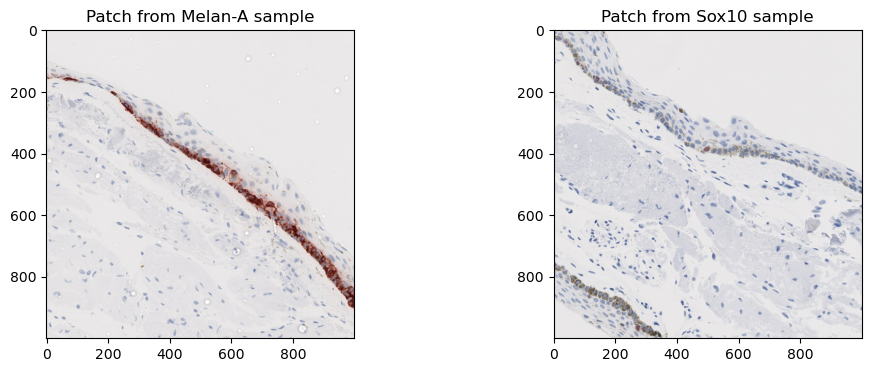

In [44]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to clean the edges of the image
def clean_edges(edges):
    blurred = cv2.GaussianBlur(edges, (5, 5), 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(blurred, kernel, iterations=1)
    cleaned_edges = cv2.erode(dilated, kernel, iterations=1)
    return cleaned_edges

# Find the largest contour by area
def find_largest_contour(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    return largest_contour

# Calculate the bounding box for the contour
def get_bounding_box(contour):
    x, y, w, h = cv2.boundingRect(contour)
    return x, y, w, h

# Function to get a random point within the contour
def get_random_point_within_contour(contour, patch_size, image_shape):
    contour_mask = np.zeros(image_shape[:2], dtype=np.uint8)
    cv2.drawContours(contour_mask, [contour], -1, 255, thickness=cv2.FILLED)
    
    # Get all points inside the contour
    y_coords, x_coords = np.where(contour_mask == 255)
    while True:
        random_index = random.randint(0, len(x_coords) - 1)
        center_x, center_y = x_coords[random_index], y_coords[random_index]

        # Ensure the selected patch stays within image bounds
        if (center_x - patch_size[0] // 2 >= 0 and
            center_y - patch_size[1] // 2 >= 0 and
            center_x + patch_size[0] // 2 <= image_shape[1] and
            center_y + patch_size[1] // 2 <= image_shape[0]):
            return center_x - patch_size[0] // 2, center_y - patch_size[1] // 2

# Function to extract a patch from specified coordinates in an image
def extract_patch(image, start_x, start_y, patch_size):
    return image[start_y:start_y+patch_size[1], start_x:start_x+patch_size[0]]

# Main pipeline function for extracting patches
def extract_patches_from_images(paths, patch_size=(1000, 1000), num_attempts=10):
    original_images = [cv2.imread(path) for path in paths]  # Load images in original color format

    # Process the first image (e.g., H&E) to find the contour and bounding box
    edges = cv2.Canny(original_images[0], 50, 100)
    cleaned_edges = clean_edges(edges)
    contours, _ = cv2.findContours(cleaned_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = find_largest_contour(contours)

    # Attempt to find a random patch within the contour
    for _ in range(num_attempts):
        try:
            start_x, start_y = get_random_point_within_contour(largest_contour, patch_size, original_images[0].shape)
            # Extract patches from the same coordinates in all images
            patches = [extract_patch(img, start_x, start_y, patch_size) for img in original_images]
            return patches  # Return patches if successfully extracted
        except:
            # If patch extraction fails, continue with a new random point
            continue
    
    raise ValueError("Could not find a valid patch with useful data after several attempts.")

# Example paths
paths = ['patient1/h1810898A mela_ROI_1.tif', 'patient1/h1810898A sox10_ROI_1.tif']

# Extract patches from images
patches = extract_patches_from_images(paths)

# Visualize the patches extracted from the images
plt.figure(figsize=(12, 4))

# Display patches in original color format
patch_titles = ['Patch from Melan-A sample', 'Patch from Sox10 sample']
for i, patch in enumerate(patches):
    plt.subplot(1, 2, i + 1)
    plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title(patch_titles[i])

plt.show()
